# Exercise 1 - Hazard Data

Generate hazard module from source data

...








### Import python libraries

In [3]:
# standard python libraries
import requests
import re
import os
from math import sin, cos, sqrt, atan2, radians

# non-standard python libraries
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

from shapely.geometry import Point
from geopandas import GeoDataFrame

# constants

#import geopy.distance
#km_nm_factor = 1.852
#earth_radius = 6373.0


### Download event data from hurdat

In [4]:
# get data from URL and write to file
raw_fn = 'source_data/raw_hurdat_data.txt'
url = 'https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2020-052921.txt'
data = requests.get(url)
with open(raw_fn,'w') as fw:
    fw.write(data.text)
    
# create an empty list to temoporarily store downloaded data
data=[]

# loop through downloaded data and parse by row
with open(raw_fn,'r') as fr:
    for row in fr:
        if row[0:2]=='AL':
            event_id=row[0:8]
            event_name=row[19:28]
            records=row[34:36]
        else:
            date=row[0:8]
            time=row[10:14]
            record_id=row[16]
            system_status=row[19:21]
            latitude=row[23:27]
            lat_hem=row[27]
            longitude=row[30:35]
            lon_hem=row[35]
            max_windspeed=row[39:41]
            min_pressure=row[43:47]
            radii_34kt_ne=row[49:53]
            radii_34kt_se=row[55:59]
            radii_34kt_sw=row[61:65]
            radii_34kt_nw=row[67:71]
            radii_50kt_ne=row[73:77]
            radii_50kt_se=row[79:83]
            radii_50kt_sw=row[85:89]
            radii_50kt_nw=row[91:95]
            radii_64kt_ne=row[97:101]
            radii_64kt_se=row[103:107]
            radii_64kt_sw=row[109:113]
            radii_64kt_nw=row[115:119]
            
            row_data = [
                event_id,
                event_name,
                records,
                date,
                time,
                record_id,
                system_status,
                latitude,
                lat_hem,
                longitude,
                lon_hem,
                max_windspeed,
                min_pressure,
                radii_34kt_ne,
                radii_34kt_se,
                radii_34kt_sw,
                radii_34kt_nw,
                radii_50kt_ne,
                radii_50kt_se,
                radii_50kt_sw,
                radii_50kt_nw,
                radii_64kt_ne,
                radii_64kt_se,
                radii_64kt_sw,
                radii_64kt_nw
            ]
            data.append(row_data)
    
# create a pandas dataframe with the list data
cols = ['id','name','records','date','time','record_id','system_status','latitude',
        'lat_hem','longitude','lon_hem','max_windspeed','min_pressure',
        'radii_34kt_ne','radii_34kt_se','radii_34kt_sw','radii_34kt_nw',
        'radii_50kt_ne','radii_50kt_se','radii_50kt_sw','radii_50kt_nw',
        'radii_64kt_ne','radii_64kt_se','radii_64kt_sw','radii_64kt_nw']



df_data=pd.DataFrame(data=data,columns=cols)

dtypes = {'id':str,'name':str,'records':int,'date':int,'time':int,
          'record_id':str,'system_status':str,'latitude':float,'lat_hem':str,
          'longitude':float,'lon_hem':str,'max_windspeed':int,'min_pressure':int,
          'radii_34kt_ne':int,'radii_34kt_se':int,'radii_34kt_sw':int,'radii_34kt_nw':int,
          'radii_50kt_ne':int,'radii_50kt_se':int,'radii_50kt_sw':int,'radii_50kt_nw':int,
          'radii_64kt_ne':int,'radii_64kt_se':int,'radii_64kt_sw':int,'radii_64kt_nw':int}

df_data = df_data.astype(dtypes)

# strip leading spaces
df_data['name']=df_data['name'].str.strip()

# set negative longitudes for western hemisphere
df_data['longitude']=-df_data['longitude']

# write the dataframe out to csv
formatted_fn = 'source_data/formatted_hurdat_data.csv'
df_data.to_csv(formatted_fn,index=False)

df_data

,id,name,records,date,time,record_id,system_status,latitude,lat_hem,longitude,...,radii_34kt_sw,radii_34kt_nw,radii_50kt_ne,radii_50kt_se,radii_50kt_sw,radii_50kt_nw,radii_64kt_ne,radii_64kt_se,radii_64kt_sw,radii_64kt_nw
0,AL011851,UNNAMED,14,18510625,0,,HU,28.0,N,-94.8,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,14,18510625,600,,HU,28.0,N,-95.4,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,14,18510625,1200,,HU,28.0,N,-96.0,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,14,18510625,1800,,HU,28.1,N,-96.5,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,14,18510625,2100,L,HU,28.2,N,-96.8,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52712,AL312020,IOTA,26,20201117,1200,,HU,13.7,N,-84.7,...,50,160,60,40,0,50,30,0,0,20
52713,AL312020,IOTA,26,20201117,1800,,TS,13.7,N,-85.7,...,0,140,60,0,0,0,0,0,0,0
52714,AL312020,IOTA,26,20201118,0,,TS,13.8,N,-86.7,...,0,130,0,0,0,0,0,0,0,0
52715,AL312020,IOTA,26,20201118,600,,TS,13.8,N,-87.8,...,0,0,0,0,0,0,0,0,0,0


### Inspect the data for Hurricane HARVEY

In [5]:
# df_data = pd.read_csv('source_data/formatted_hurdat_data.csv')

df_data[df_data['id']=='AL092017'].head(20)

,id,name,records,date,time,record_id,system_status,latitude,lat_hem,longitude,...,radii_34kt_sw,radii_34kt_nw,radii_50kt_ne,radii_50kt_se,radii_50kt_sw,radii_50kt_nw,radii_64kt_ne,radii_64kt_se,radii_64kt_sw,radii_64kt_nw
50252,AL092017,HARVEY,74,20170816,600,,LO,13.7,N,-45.8,...,0,0,0,0,0,0,0,0,0,0
50253,AL092017,HARVEY,74,20170816,1200,,LO,13.7,N,-47.4,...,0,0,0,0,0,0,0,0,0,0
50254,AL092017,HARVEY,74,20170816,1800,,LO,13.6,N,-49.0,...,0,0,0,0,0,0,0,0,0,0
50255,AL092017,HARVEY,74,20170817,0,,LO,13.6,N,-50.6,...,0,0,0,0,0,0,0,0,0,0
50256,AL092017,HARVEY,74,20170817,600,,TD,13.4,N,-52.0,...,0,0,0,0,0,0,0,0,0,0
50257,AL092017,HARVEY,74,20170817,1200,,TD,13.1,N,-53.4,...,0,0,0,0,0,0,0,0,0,0
50258,AL092017,HARVEY,74,20170817,1800,,TS,13.0,N,-55.0,...,0,30,0,0,0,0,0,0,0,0
50259,AL092017,HARVEY,74,20170818,0,,TS,13.0,N,-56.6,...,0,50,0,0,0,0,0,0,0,0
50260,AL092017,HARVEY,74,20170818,600,,TS,13.0,N,-58.4,...,0,50,0,0,0,0,0,0,0,0
50261,AL092017,HARVEY,74,20170818,1000,L,TS,13.1,N,-59.6,...,0,50,0,0,0,0,0,0,0,0


## Get model area grid

In [6]:
# get events which make happened since 2000
df_data_in_period = df_data[df_data['date']>=20000101]

df_data_in_period

,id,name,records,date,time,record_id,system_status,latitude,lat_hem,longitude,...,radii_34kt_sw,radii_34kt_nw,radii_50kt_ne,radii_50kt_se,radii_50kt_sw,radii_50kt_nw,radii_64kt_ne,radii_64kt_se,radii_64kt_sw,radii_64kt_nw
41585,AL012000,UNNAMED,4,20000607,1800,,TD,21.0,N,-93.0,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
41586,AL012000,UNNAMED,4,20000608,0,,TD,20.9,N,-92.8,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
41587,AL012000,UNNAMED,4,20000608,600,,TD,20.7,N,-93.1,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
41588,AL012000,UNNAMED,4,20000608,1200,,TD,20.8,N,-93.5,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
41589,AL022000,UNNAMED,12,20000623,0,,TD,9.5,N,-19.8,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52712,AL312020,IOTA,26,20201117,1200,,HU,13.7,N,-84.7,...,50,160,60,40,0,50,30,0,0,20
52713,AL312020,IOTA,26,20201117,1800,,TS,13.7,N,-85.7,...,0,140,60,0,0,0,0,0,0,0
52714,AL312020,IOTA,26,20201118,0,,TS,13.8,N,-86.7,...,0,130,0,0,0,0,0,0,0,0
52715,AL312020,IOTA,26,20201118,600,,TS,13.8,N,-87.8,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# combine data
df_events = df_data_in_period['id'].drop_duplicates().reset_index()[['id']]
df_events['event_id']=df_events.index+1

df_events

,id,event_id
0,AL012000,1
1,AL022000,2
2,AL032000,3
3,AL042000,4
4,AL052000,5
...,...,...
365,AL272020,366
366,AL282020,367
367,AL292020,368
368,AL302020,369


In [8]:
# add the event ids into the data dataframe
df_data_in_period = df_data_in_period.merge(df_events,on='id')

In [9]:
df_grid = pd.read_csv('source_data/us_grid.csv')

df_grid

,latitude,longitude
0,24.7,-81.3
1,25.2,-81.0
2,25.2,-80.9
3,25.2,-80.7
4,25.2,-80.4
...,...,...
37704,45.0,-67.5
37705,45.0,-67.4
37706,45.0,-67.3
37707,45.0,-67.2


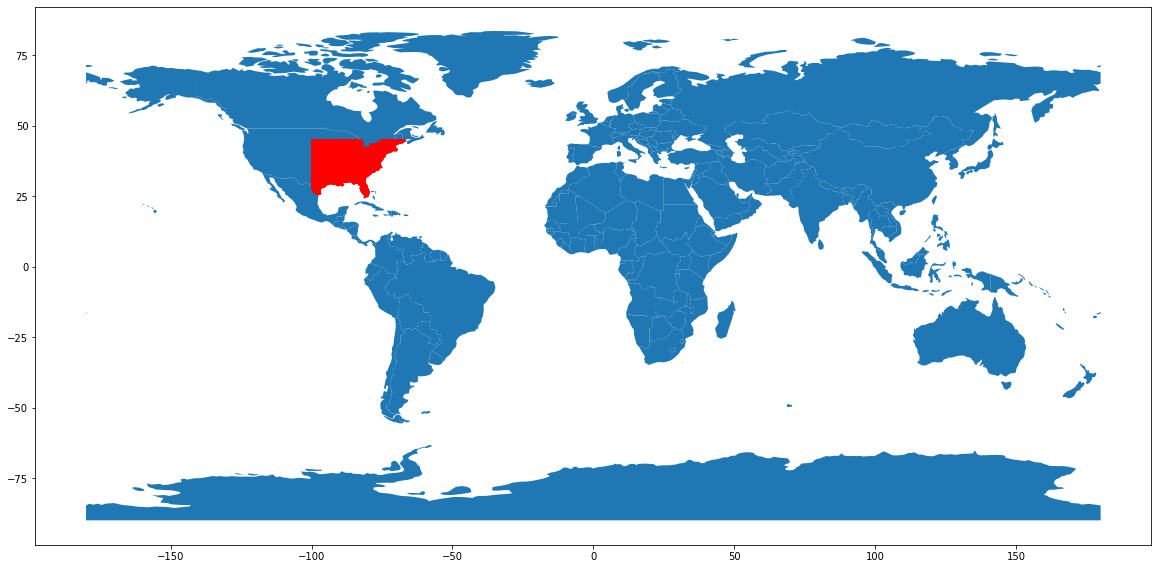

In [10]:
# show grid
geometry = [Point(xy) for xy in zip(df_grid['longitude'], df_grid['latitude'])]
gdf = GeoDataFrame(df_grid, geometry=geometry)   

#this is a simple map that comes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(20, 12)), marker='o', color='red', markersize=1);

In [11]:
# create cartisian indicies
df_x = df_grid[['latitude']].drop_duplicates().reset_index()[['latitude']]
df_x['x_index']=df_x.index+1

df_y = df_grid[['longitude']].drop_duplicates().reset_index()[['longitude']]
df_y['y_index']=df_y.index+1

df_grid_coord = df_grid.merge(df_x,on='latitude').merge(df_y,on='longitude')

# create area peril id for grid
df_grid_coord['area_peril_id']=df_grid_coord.index+1

del df_grid_coord['geometry']

df_grid_coord

,latitude,longitude,x_index,y_index,area_peril_id
0,24.7,-81.3,1,1,1
1,25.9,-81.3,9,1,2
2,26.0,-81.3,10,1,3
3,26.1,-81.3,11,1,4
4,26.2,-81.3,12,1,5
...,...,...,...,...,...
37704,44.9,-67.2,199,328,37705
37705,45.0,-67.2,200,328,37706
37706,44.8,-67.1,198,329,37707
37707,45.0,-67.1,200,329,37708


In [12]:
# find areaperil cell of track point
df_events_ap = df_data_in_period.merge(df_grid_coord,on=['latitude','longitude'])

df_events_ap

,id,name,records,date,time,record_id,system_status,latitude,lat_hem,longitude,...,radii_50kt_sw,radii_50kt_nw,radii_64kt_ne,radii_64kt_se,radii_64kt_sw,radii_64kt_nw,event_id,x_index,y_index,area_peril_id
0,AL092000,UNNAMED,6,20000909,1000,L,TD,29.9,N,-93.9,...,-999,-999,-999,-999,-999,-999,9,49,131,20845
1,AL092000,UNNAMED,6,20000909,1200,,TD,30.0,N,-94.0,...,-999,-999,-999,-999,-999,-999,9,50,130,20693
2,AL112000,GORDON,29,20000918,600,,TS,29.8,N,-83.0,...,-999,-999,-999,-999,-999,-999,11,48,84,13583
3,AL062008,FAY,60,20080822,1800,,TS,29.8,N,-83.0,...,0,0,0,0,0,0,151,48,84,13583
4,AL012013,ANDREA,14,20130607,0,,TS,29.8,N,-83.0,...,0,0,0,0,0,0,234,48,84,13583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,AL262020,DELTA,31,20201010,1800,,EX,33.3,N,-90.6,...,0,0,0,0,0,0,365,83,91,14717
570,AL262020,DELTA,31,20201011,1200,,EX,34.8,N,-87.5,...,0,0,0,0,0,0,365,98,177,27811
571,AL282020,ZETA,25,20201029,600,,TS,32.8,N,-87.5,...,0,0,0,0,0,0,367,78,177,27791
572,AL282020,ZETA,25,20201029,1800,,EX,37.8,N,-78.2,...,0,0,0,0,0,0,367,128,218,32951


In [13]:
# remove records below windspeed threhold
v_thresh = 45
df_events_thresh = df_events_ap[df_events_ap['max_windspeed'] >= v_thresh]

df_events_thresh

,id,name,records,date,time,record_id,system_status,latitude,lat_hem,longitude,...,radii_50kt_sw,radii_50kt_nw,radii_64kt_ne,radii_64kt_se,radii_64kt_sw,radii_64kt_nw,event_id,x_index,y_index,area_peril_id
18,AL012001,ALLISON,57,20010606,0,,TS,29.3,N,-95.3,...,-999,-999,-999,-999,-999,-999,20,43,75,12181
48,AL032001,BARRY,25,20010806,600,,TS,30.6,N,-86.4,...,-999,-999,-999,-999,-999,-999,22,56,196,30542
56,AL082001,GABRIELLE,41,20010914,1800,,TS,28.0,N,-81.8,...,-999,-999,-999,-999,-999,-999,27,30,35,5566
66,AL092012,ISAAC,51,20120830,600,,TS,30.6,N,-91.5,...,0,0,0,0,0,0,223,56,126,20085
85,AL092002,HANNA,17,20020914,1500,L,TS,30.4,N,-88.4,...,-999,-999,-999,-999,-999,-999,45,54,175,27473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,AL192020,SALLY,28,20200916,1800,,TS,31.1,N,-87.2,...,30,20,0,0,0,0,358,61,190,29674
566,AL262020,DELTA,31,20201010,0,,HU,30.1,N,-92.9,...,40,40,20,20,20,20,365,51,136,21610
567,AL262020,DELTA,31,20201010,600,,TS,31.4,N,-92.2,...,0,0,0,0,0,0,365,64,108,17325
571,AL282020,ZETA,25,20201029,600,,TS,32.8,N,-87.5,...,0,0,0,0,0,0,367,78,177,27791


In [14]:
df_events_thresh[['id','name']].drop_duplicates()

,id,name
18,AL012001,ALLISON
48,AL032001,BARRY
56,AL082001,GABRIELLE
66,AL092012,ISAAC
85,AL092002,HANNA
90,AL102002,ISIDORE
99,AL132002,LILI
104,AL032003,BILL
111,AL042003,CLAUDETTE
122,AL132003,ISABEL


In [15]:
# index windspeeds and assign size
df_intensity = df_events_thresh['max_windspeed'].drop_duplicates().sort_values().reset_index()
df_intensity['intensity_bin_index']=df_intensity.index+1

df_intensity = df_intensity[['intensity_bin_index','max_windspeed']]

df_intensity

,intensity_bin_index,max_windspeed
0,1,45
1,2,50
2,3,55
3,4,60
4,5,65
5,6,70
6,7,75
7,8,80
8,9,85
9,10,90


In [16]:
df_events_intensity = df_events_thresh.merge(df_intensity,on='max_windspeed').sort_values(by=['date','time'])
df_events_intensity

,id,name,records,date,time,record_id,system_status,latitude,lat_hem,longitude,...,radii_50kt_nw,radii_64kt_ne,radii_64kt_se,radii_64kt_sw,radii_64kt_nw,event_id,x_index,y_index,area_peril_id,intensity_bin_index
0,AL012001,ALLISON,57,20010606,0,,TS,29.3,N,-95.3,...,-999,-999,-999,-999,-999,20,43,75,12181,1
26,AL032001,BARRY,25,20010806,600,,TS,30.6,N,-86.4,...,-999,-999,-999,-999,-999,22,56,196,30542,4
1,AL082001,GABRIELLE,41,20010914,1800,,TS,28.0,N,-81.8,...,-999,-999,-999,-999,-999,27,30,35,5566,1
56,AL092002,HANNA,17,20020914,1500,L,TS,30.4,N,-88.4,...,-999,-999,-999,-999,-999,45,54,175,27473,2
41,AL102002,ISIDORE,55,20020926,1200,,TS,30.0,N,-89.9,...,-999,-999,-999,-999,-999,46,50,114,18233,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,AL192020,SALLY,28,20200916,1800,,TS,31.1,N,-87.2,...,20,0,0,0,0,358,61,190,29674,4
113,AL262020,DELTA,31,20201010,0,,HU,30.1,N,-92.9,...,40,20,20,20,20,365,51,136,21610,7
78,AL262020,DELTA,31,20201010,600,,TS,31.4,N,-92.2,...,0,0,0,0,0,365,64,108,17325,2
39,AL282020,ZETA,25,20201029,600,,TS,32.8,N,-87.5,...,0,0,0,0,0,367,78,177,27791,4


In [17]:
df_events_intensity = df_events_thresh.merge(df_intensity,on='max_windspeed').sort_values(by=['date','time'])

# generate intensity values per event & areaperil


lst_fp = []

for index, row in df_events_intensity.iterrows():
    #print(row[['area_peril_id','x_index','y_index','intensity_bin_index','event_id']])
    i=0
    event_id = row['event_id']
    area_peril_id = row['area_peril_id']
    intensity_bin = row['intensity_bin_index']
        
    row_fp = [event_id,area_peril_id,intensity_bin]
    lst_fp.append(row_fp)
    
    #### to do - add in radius ####
    
    #if radius > 1:
    #    for r in range(radius):
    #        
    #    
    #for i in range(radius):
    #    i+=1
    #    print(event_id, radius, i)
    
df_footprint = pd.DataFrame(data=lst_fp,columns=['event_id','area_peril_id','intensity_bin_index'],dtype='int')
df_footprint['probability']=1

df_footprint
    

,event_id,area_peril_id,intensity_bin_index,probability
0,20,12181,1,1
1,22,30542,4,1
2,27,5566,1,1
3,45,27473,2,1
4,46,18233,3,1
...,...,...,...,...
109,358,29674,4,1
110,365,21610,7,1
111,365,17325,2,1
112,367,27791,4,1


In [18]:
# write model files out
df_events[['event_id','id']].to_csv('model_data/events.csv',index=False)
df_footprint.to_csv('model_data/footprint.csv',index=False)
df_intensity.to_csv('model_data/intensity_bin_dict.csv',index=False)

In [19]:
# write keys data out
df_grid_coord[['area_peril_id','latitude','longitude']].to_csv('keys_data/areaperil_dict.csv',index=False)

In [50]:
# write occurrence file
df_event_dates = df_events_intensity.groupby(['id'])[['date']].min().merge(df_events,on='id')
df_event_dates['date_str']=df_event_dates['date'].astype('str')
df_event_dates['occ_year']=df_event_dates['date_str'].apply(lambda x: int(x[0:4]))
df_event_dates['occ_month']=df_event_dates['date_str'].apply(lambda x: int(x[4:6]))
df_event_dates['occ_day']=df_event_dates['date_str'].apply(lambda x: int(x[6:8]))

year_min = df_event_dates['occ_year'].min()
df_event_dates['period_no']=df_event_dates['occ_year'] - year_min + 1

df_occurrence = df_event_dates[['event_id','period_no','occ_year','occ_month','occ_day']].sort_values(
    by=['period_no','event_id'])

df_occurrence.to_csv('model_data/occurrence.csv',index=False)

df_occurrence

,event_id,period_no,occ_year,occ_month,occ_day
0,20,1,2001,6,6
5,22,1,2001,8,6
20,27,1,2001,9,14
23,45,2,2002,9,14
32,46,2,2002,9,26
38,49,2,2002,10,3
6,53,3,2003,6,30
10,54,3,2003,7,15
39,63,3,2003,9,19
13,77,4,2004,9,5


In [49]:
# write return period file
with open('model_data/returnperiods.csv','w') as rp:
    rp.write('20\n10\n5\n3\n2\n1')
             
! cat model_data/returnperiods.csv

20
10
5
3
2
1

In [ ]:
df_events['key']=1
df_grid['key']=1

lon_lat_tollerance = 1

e_id = 'AL092017'

min_lat = df_events[df_events['id']==e_id]['latitude'].min() - lon_lat_tollerance
max_lat = df_events[df_events['id']==e_id]['latitude'].max() + lon_lat_tollerance
min_lon = df_events[df_events['id']==e_id]['longitude'].min() - lon_lat_tollerance
max_lon = df_events[df_events['id']==e_id]['longitude'].max() + lon_lat_tollerance

print(min_lat,max_lat,min_lon,max_lon)

df_grid_e = df_grid[
    (df_grid['grid_latitude']>=min_lat) &
    (df_grid['grid_latitude']<=max_lat) &
    (df_grid['grid_longitude']<=-min_lon) &
    (df_grid['grid_longitude']>=-max_lon)
]


df_e = df_events[df_events['id']==e_id].merge(df_grid_e)



#df_e[['latitude','longitude','grid_latitude','grid_longitude']] 

df_e['distance'] = df_e.apply(lambda x: get_distance(
    x['latitude'],
    x['longitude'],
    x['grid_latitude'],
    x['grid_longitude']),axis=1)

df_e

In [ ]:
df_e.sort_values(by='distance')

In [ ]:
get_distance(44.95,-67.25,44.95,-67.15)

In [ ]:
df_events['radii_34kt_nw'].astype('float').max() 

In [ ]:
df_events[df_events['radii_34kt_nw'].str.strip()=='600']
df_data[df_data['id'].str.strip()=='AL012016'].head(42)

In [ ]:
df_events[['id','name']].drop_duplicates().tail(50)

In [ ]:
# create function to calculate distance between two lat-lon points

def get_distance(lat1,lon1,lat2,lon2):
    lat1_r = radians(abs(lat1))
    lon1_r = radians(abs(lon1))
    lat2_r = radians(abs(lat2))
    lon2_r = radians(abs(lon2))

    dlon = lon2_r - lon1_r
    dlat = lat2_r - lat1_r

    a = sin(dlat / 2)**2 + cos(lat1_r) * cos(lat2_r) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = earth_radius * c

    return distance